In [1]:
import os
import pandas as pd

HOUSING_PATH = os.path.join("datasets", "housing")

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv") # join() - joins two path elements intelligently.
    return pd.read_csv(csv_path)

In [2]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
import numpy as np

np.random.seed(42) #Generates the same shuffled indices.

#Function to set aside a portion of the dataset for testing the model
#This is not an optimum solution, because every time this is run it generates a new test set, ultimately convering the whole dataset
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data)) #Randomly permutes the length of the dataset to select random data elements
    test_set_size = int(len(data) * test_ratio)         #Converts the result of len(data) * test_ratio into an integer
    test_indices = shuffled_indices[:test_set_size]     #Selects all elements from the beginning of the array upto the value of test_set_size
    train_indices = shuffled_indices[test_set_size:]    #Selects all elements after the value of test_set_size
    return data.iloc[train_indices], data.iloc[test_indices] #iloc gets rows (or columns) at particular positions in the index

train_set, test_set = split_train_test(housing, 0.2)    #Calls split_test_train
print(len(train_set), "train +", len(test_set), "test")

C:\Users\SA20020654\AppData\Local\Continuum\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [4]:
#Alternate implementation for creating a test set involves computing the hash of each element's identifier, keeping only the last byte of the hash
#& add the element to the test set only if the value of the last byte exceeds some specific value. 
#This ensures that same elements are part of the test set across multiple runs.
#The implementation below was only supported for lower versions of Python, & was slow.

import hashlib
def test_set_check(identifier, test_ratio, hash):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

housing_with_id = housing.reset_index()   # adds an `index` column
print(housing_with_id)
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


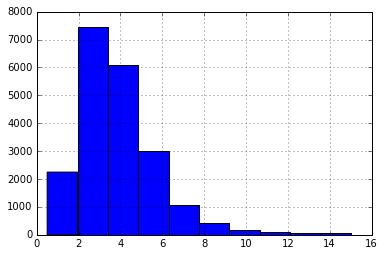

In [7]:
#implementation of test_set_check() that works fine in both Python 2 and Python 3
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [10]:
housing_with_id = housing.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")
print(len(train_set), "train +", len(test_set), "test")

In [11]:
housing["income_cat"].value_counts()

3.0    7236
2.0    6581
4.0    3639
5.0    2362
1.0     822
Name: income_cat, dtype: int64